# Scaling-up Deep Learning Inference to Large-Scale Bioimage Data (part 2)

## Contact info:
- Fernando Cervantes
- Systems Analyst in JAX's Research IT
- email: fernando.cervantes@jax.org

# 1. [Optional] Convert a Tiff into Zarr format with `bioformats2raw`

Open a terminal (e.g. from the Launcher) and use the following command:

```
bioformats2raw CMU-1_Crop.ome.tif CMU-1_Crop.ome.zarr --use-existing-resolutions -p
```

Alternatively, download the pre-converted image from [here](https://drive.google.com/file/d/1BmNxOrO3vOFPR-PCnV00DYgFsD1sDu47/view?usp=sharing).

---
# 2. Compute on Zarr arrays

## 2.1 Set up a Dask cluster

- [ ] Use the Jupyter's Dask extension to start a distributed cluster
- [ ] Click the "+ New" button at the bottom of the plugin

![image](dask_extension.png)

- [ ] Click the "<>" button to inject the code needed to connect with this cluster

![image](dask_extension_ready.png)

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:60666")
client

<Client: 'tcp://127.0.0.1:60666' processes=4 threads=8, memory=23.84 GiB>

{0: {'shape': (17935, 18865, 3), 'num-chunks': (36, 37, 1), 'array-location': [(8192, 8704), (2048, 2560), (0, 3)], 'chunk-location': (16, 4, 0)}, None: {'shape': (17935, 18865), 'num-chunks': (36, 37), 'array-location': [(8192, 8704), (2048, 2560)], 'chunk-location': (16, 4), 'chunk-shape': (512, 512), 'dtype': <class 'numpy.int32'>}} Input chunk shape (512, 512, 3) Output shape (512, 512)
{0: {'shape': (17935, 18865, 3), 'num-chunks': (36, 37, 1), 'array-location': [(8192, 8704), (1536, 2048), (0, 3)], 'chunk-location': (16, 3, 0)}, None: {'shape': (17935, 18865), 'num-chunks': (36, 37), 'array-location': [(8192, 8704), (1536, 2048)], 'chunk-location': (16, 3), 'chunk-shape': (512, 512), 'dtype': <class 'numpy.int32'>}} Input chunk shape (512, 512, 3) Output shape (512, 512)
{0: {'shape': (17935, 18865, 3), 'num-chunks': (36, 37, 1), 'array-location': [(7680, 8192), (2048, 2560), (0, 3)], 'chunk-location': (15, 4, 0)}, None: {'shape': (17935, 18865), 'num-chunks': (36, 37), 'array-lo

In [3]:
import zarr
import dask
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import skimage

Change this to the actual path where the image is stored

In [4]:
input_path = r"C:\Users\Public\Documents\WSI_example\CMU-1_Crop.ome.zarr"

In [5]:
z_grp = zarr.open(input_path, mode="r")

In [6]:
z_grp.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,2
No. arrays,0
No. groups,2
Groups,"0, OME"


In [7]:
z_grp["0"].info

Name,/0
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,3
No. arrays,3
No. groups,0
Arrays,"0, 1, 2"


In [8]:
da_arr = da.from_zarr(input_path, component="0/0")

In [9]:
da_arr

dask.array<from-zarr, shape=(1, 3, 1, 17935, 18865), dtype=uint8, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>

In [10]:
da_arr = da_arr[0, :, 0].rechunk((3, 512, 512))

In [11]:
da_arr

dask.array<rechunk-merge, shape=(3, 17935, 18865), dtype=uint8, chunksize=(3, 512, 512), chunktype=numpy.ndarray>

In [12]:
da_arr = np.moveaxis(da_arr, 0, -1)

In [13]:
da_arr

dask.array<transpose, shape=(17935, 18865, 3), dtype=uint8, chunksize=(512, 512, 3), chunktype=numpy.ndarray>

In [14]:
da_sel = da_arr[8_000:8_000+512, 2_000:2_000+512]

In [15]:
da_sel

dask.array<getitem, shape=(512, 512, 3), dtype=uint8, chunksize=(320, 464, 3), chunktype=numpy.ndarray>

---
# 3. [Example] Segmentation of nuclei in WSI (Cellpose)

- [ ] Load the `cyto3` pre-trained model from Cellpose library 

In [16]:
from cellpose import models, transforms
import torch

gpu = torch.cuda.is_available()
model_type = "cyto3"

cellpose_model = models.CellposeModel(gpu=gpu, model_type=model_type)

In [17]:
cellpose_model

---
## 3.1 Compute as numpy array (`.compute()`)

In [18]:
img_t = transforms.convert_image(da_sel.compute(), channel_axis=2, channels=[0, 0])
img_t = transforms.normalize_img(img_t, invert=False, axis=2)

labels, _, _ = cellpose_model.eval(img_t[None, ...], diameter=None, flow_threshold=None, channels=[0, 0])

In [19]:
labels.shape

(512, 512)

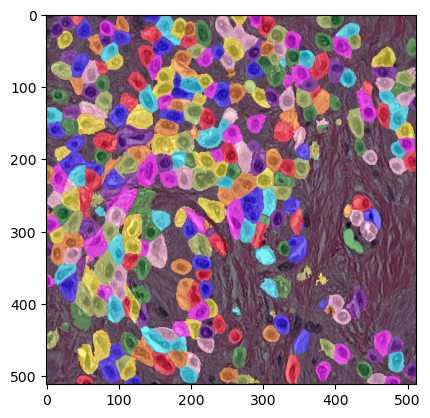

In [20]:
plt.imshow(da_sel)
plt.imshow(skimage.color.label2rgb(labels), alpha=0.5)

---
## 3.2 Compute the segmentation lazily with Dask (`delayed`)

- [ ] Define the inference pipeline as a function that can be applied to an image chunk
- [ ] Use `dask.delayed` to convert it into a lazy function
- [ ] Create a `dask.array` from the delayed output of the lazy function with `dask.array.from_delayed` (`da.from_delayed`)

In [21]:
def cellpose_segment_chunk(img, model_type="nuclei", gpu=False):
    worker = dask.distributed.get_worker()
    with worker._lock:
        if not hasattr(worker, "_cellpose_model"):
            worker._cellpose_model = models.CellposeModel(gpu=gpu, model_type=model_type)

    img_t = transforms.convert_image(img, channel_axis=2, channels=[0, 0])
    img_t = transforms.normalize_img(img_t, invert=False, axis=2)

    labels, _, _ = worker._cellpose_model.eval(img_t[None, ...], diameter=None, flow_threshold=None, channels=[0, 0])
    return labels

In [22]:
delayed_labels_sel = dask.delayed(cellpose_segment_chunk)(da_sel, "nuclei", torch.cuda.is_available())

In [23]:
delayed_labels_sel

Delayed('cellpose_segment_chunk-ea6e405a-734b-469a-94f7-039bca50f788')

In [24]:
labels_sel = da.from_delayed(delayed_labels_sel, shape=da_sel.shape[:2], dtype=np.int32)

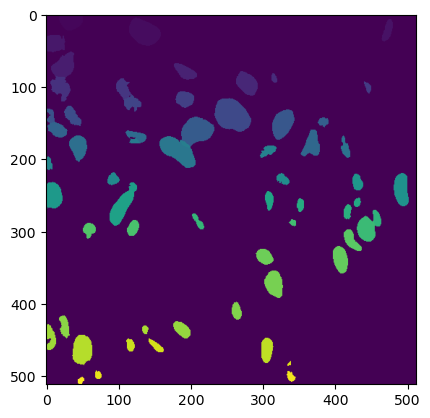

In [25]:
plt.imshow(labels_sel)

---
## 3.3 Distribute computation with `map_blocks`

- [ ] Use the `dask.array.map_blocks` (`da.map_blocks`) function to apply the inference pipeline to the whole image

In [27]:
da_labels = da.map_blocks(
    cellpose_segment_chunk,
    da_arr,
    model_type="nuclei",
    gpu=torch.cuda.is_available(),
    drop_axis=(2, ),
    dtype=np.int32,
    meta=np.empty(0, dtype=np.int32)
)

In [28]:
da_labels

dask.array<cellpose_segment_chunk, shape=(17935, 18865), dtype=int32, chunksize=(512, 512), chunktype=numpy.ndarray>

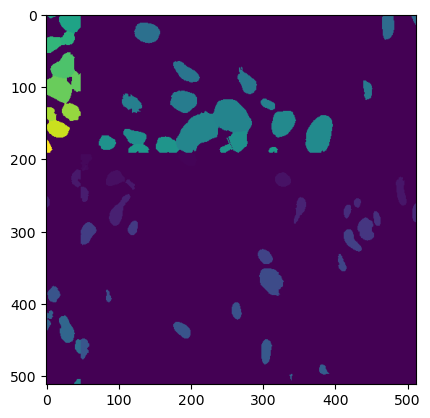

In [29]:
plt.imshow(da_labels[8_000:8_000+512, 2_000:2_000+512])

- [ ] Create an overlay of the labels generated by the inference pipeline on top of the image pixels. Use 'skimage.color.label2rgb', but this will require to use `.compute()`

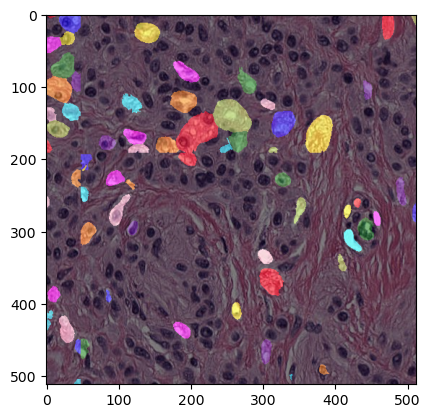

In [30]:
plt.imshow(da_arr[8_000:8_000+512, 2_000:2_000+512])
plt.imshow(skimage.color.label2rgb(da_labels[8_000:8_000+512, 2_000:2_000+512].compute()), alpha=0.5)

- [ ] Use the `.blocks` property of `dask.array`s to access the pixels with a chunk/block-based coordinate system

In [31]:
da_arr.blocks.shape

(36, 37, 1)

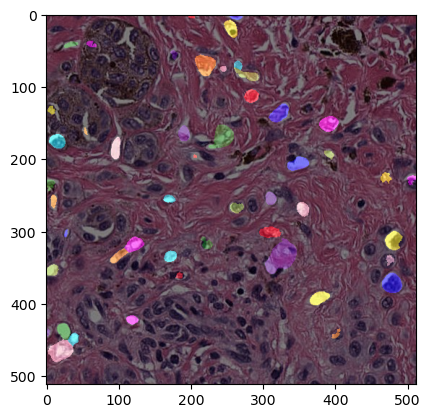

In [32]:
plt.imshow(da_arr.blocks[10, 5])
plt.imshow(skimage.color.label2rgb(da_labels.blocks[10, 5].compute()), alpha=0.5)

---
## 3.4 Debug `map_blocks` computations

- [ ] Show the Log Console and change the log level to "Info"
- [ ] Import the replacement of the `print` function from `dask.distributed`. Import it as `dask_print` to prevent issues with the regular `print` function
- [ ] Test what happens when we don't use `drop_axis` argument in `dask.array.map_blocks` (`da.map_blocks`)
- [ ] Add a `dask_print` statement in `cellpose_segment` function to investigate what is the problem

In [33]:
from dask.distributed import print as dask_print

In [40]:
def cellpose_segment_debug(img, model_type="nuclei", gpu=False, block_info=None):
    worker = dask.distributed.get_worker()
    with worker._lock:
        if not hasattr(worker, "_cellpose_model"):
            worker._cellpose_model = models.CellposeModel(gpu=gpu, model_type=model_type)

    img_t = transforms.convert_image(img, channel_axis=2, channels=[0, 0])
    img_t = transforms.normalize_img(img_t, invert=False, axis=2)

    labels, _, _ = worker._cellpose_model.eval(img_t[None, ...], diameter=None, flow_threshold=None, channels=[0, 0])

    dask_print(block_info, "Input chunk shape", img.shape, "Output shape", labels.shape)
    return labels

In [41]:
da_labels = da.map_blocks(
    cellpose_segment_debug,
    da_arr,
    model_type="nuclei",
    gpu=torch.cuda.is_available(),
    drop_axis=(2, ),
    dtype=np.int32,
    meta=np.empty(0, dtype=np.int32)
)

In [42]:
labels = da_labels[8_000:8_000+512, 2_000:2_000+512].compute()

---
## 3.5 Return arrays with different shape with `map_blocks`

- [ ] Add a post-processing step to convert the outputs from the segmentation pipeline into a set of region properties (`skimage.measure.regionprops`)
    - Note that now the output of this function is a $1\times1$ array

In [43]:
def rprops(img, labels, block_info=None):
    tl_y = block_info[0]["array-location"][0][0]
    tl_x = block_info[0]["array-location"][1][0]

    rprops = skimage.measure.regionprops(labels[..., 0], intensity_image=img)

    features_arr = np.array([[dict(rprops=rprops, offset=(tl_y, tl_x))]], dtype=object)

    return features_arr

In [44]:
da_rprops = da.map_blocks(
    rprops,
    da_arr,
    da_labels[..., None],
    chunks=(1, 1),
    drop_axis=(2,),
    dtype=object,
    meta=np.empty(0, dtype=object)
)

In [45]:
da_rprops

dask.array<rprops, shape=(36, 37), dtype=object, chunksize=(1, 1), chunktype=numpy.ndarray>

In [46]:
rprops_dict = da_rprops[10, 10].compute()

In [47]:
rprops_dict["rprops"][0].intensity_mean

array([227.2866242 , 215.42675159, 226.89171975])

---
# 4. [Example] Compute on masked chunks

## 4.1 Compute a mask from a low-resolution level of the input *pyramid*

- [ ] Compute a low-resolution mask using image processing
  - Use the downsampled image at level $2$ from input .zarr file ("0/2")
  - Convert the color image into grayscale
  - Smooth the image and apply a fixed threshold on all chunks
  - Downscale the mask to represent a $512\times512$ pixels region with a single pixel of the mask with an aggregation function (i.e. `.sum()`, `.mean()`)

In [48]:
da_lowres = da.from_zarr(input_path, component="0/2")
da_lowres

dask.array<from-zarr, shape=(1, 3, 1, 717, 754), dtype=uint8, chunksize=(1, 1, 1, 717, 754), chunktype=numpy.ndarray>

In [49]:
list(map(len, da_arr.chunks))

[36, 37, 1]

In [50]:
import operator

list(map(operator.truediv, da_lowres.shape[-2:], map(len, da_arr.chunks[:2])))

[19.916666666666668, 20.37837837837838]

In [51]:
da_lowres = da.rechunk(np.moveaxis(da_lowres[0, :, 0], 0, -1), (20, 20, 3))

In [52]:
da_lowres

dask.array<rechunk-merge, shape=(717, 754, 3), dtype=uint8, chunksize=(20, 20, 3), chunktype=numpy.ndarray>

In [53]:
list(map(len, da_lowres.chunks))

[36, 38, 1]

In [54]:
da_lowres = da_lowres.blocks[:, :37, :]

In [55]:
da_lowres.blocks.shape

(36, 37, 1)

In [56]:
def compute_mask_chunk(lowres_img, threshold, sigma=2.0, min_pixels=10):
    low_res_gray = skimage.color.rgb2gray(lowres_img)
    low_res_blur = skimage.filters.gaussian(low_res_gray, sigma=sigma)

    mask = low_res_blur < threshold

    down_sampled_mask = mask.sum(keepdims=True) > min_pixels
    
    return down_sampled_mask
    

In [83]:
da_mask = da.map_blocks(
    compute_mask_chunk,
    da_lowres,
    threshold=0.7,
    sigma=2.0,
    min_pixels=200,
    drop_axis=(2,),
    chunks=(1, 1),
    dtype=np.uint8,
    meta=np.empty((0, ), dtype=np.uint8)
)

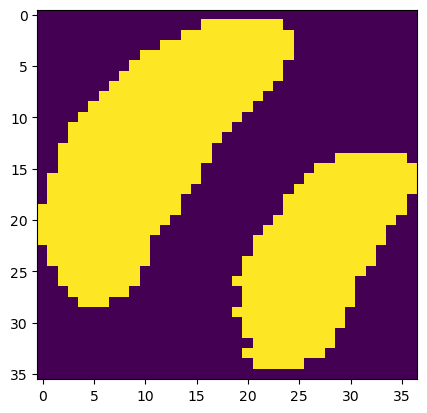

In [84]:
plt.imshow(da_mask)

In [85]:
da_mask

dask.array<compute_mask_chunk, shape=(36, 37), dtype=uint8, chunksize=(1, 1), chunktype=numpy.ndarray>

---
# 5. [Exercise] Reduce computations on map_blocks

## 5.1  Apply the deep learning segmentation pipeline only on masked regions of the image

- [ ] Add a verification step to determine whether the current image chunk should be processed or not

In [60]:
def cellpose_masked_segment(img, mask, model_type="nuclei", gpu=False, block_info=None):
    if mask.sum():
        worker = dask.distributed.get_worker()
        with worker._lock:
            if not hasattr(worker, "_cellpose_model"):
                worker._cellpose_model = models.CellposeModel(gpu=gpu, model_type=model_type)

        img_t = transforms.convert_image(img, channel_axis=2, channels=[0, 0])
        img_t = transforms.normalize_img(img_t, invert=False, axis=2)

        labels, _, _ = worker._cellpose_model.eval(img_t[None, ...], diameter=None, flow_threshold=None, channels=[0, 0])

    else:
        labels = np.zeros(block_info[None]["chunk-shape"], dtype=block_info[None]["dtype"])
    return labels

In [61]:
da_labels = da.map_blocks(
    cellpose_masked_segment,
    da_arr,
    da_mask[..., None],
    model_type="nuclei",
    gpu=torch.cuda.is_available(),
    drop_axis=(2, ),
    dtype=np.int32,
    meta=np.empty(0, dtype=np.int32)
)

In [62]:
da_labels

dask.array<cellpose_masked_segment, shape=(17935, 18865), dtype=int32, chunksize=(512, 512), chunktype=numpy.ndarray>

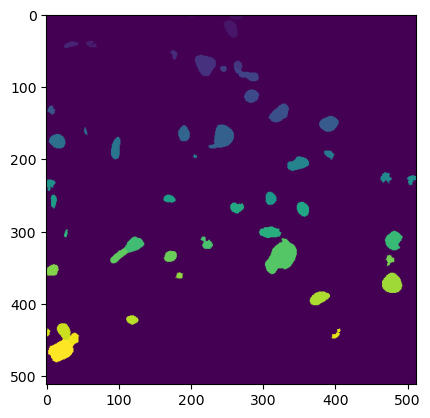

In [63]:
plt.imshow(da_labels.blocks[10, 5])

---
## 5.2 Store the segmentation as a Zarr file on disk

- [ ] Use the `.to_zarr` method of `dask.array`s to store the array's content into a **.zarr** file.
    - Note: Use the argument `write_empty_chunks=False` to avoid creating files for empty chunks on disk
- [ ] Import `ProgressBar` and use it to show the progress of the segmentation process on the whole image

In [65]:
from dask.diagnostics import ProgressBar

In [66]:
%%time
with ProgressBar():
    da_labels.to_zarr(
        "CMU-1_Crop_labels_cellpose_cyto3.zarr",
        component="0",
        write_empty_chunks=False,
        compressor=zarr.Blosc(clevel=9),
        overwrite=True
    )

---
## 5.3 Compute region properties from the stored labels

- [ ] Use the labels from disk instead of computing them again
- [ ] Apply a rule to avoid computing the region properties on chunks without any labels

In [67]:
def rprops_masked(img, labels, block_info=None):
    if (labels.max() < 1):
        return np.array([[{"rprops": []}]], dtype=object)

    tl_y = block_info[0]["array-location"][0][0]
    tl_x = block_info[0]["array-location"][1][0]

    rprops = skimage.measure.regionprops(labels[..., 0], intensity_image=img)

    features_arr = np.array([[dict(rprops=rprops, offset=(tl_y, tl_x))]], dtype=object)

    return features_arr

In [68]:
da_labels = da.from_zarr("CMU-1_Crop_labels_cellpose_cyto3.zarr", component="0")

In [69]:
da_rprops = da.map_blocks(
    rprops_masked,
    da_arr,
    da_labels[..., None],
    drop_axis=(2, ),
    chunks=(1, 1),
    dtype=object,
    meta=np.empty((0, ), dtype=object)
)

In [70]:
da_rprops[10, 5].compute()["rprops"]

In [71]:
%%time
with ProgressBar():
    rprops_arr = da_rprops.compute()

In [72]:
rprops_arr.shape

(36, 37)

In [73]:
rprops_arr[10, 10]["rprops"][0].perimeter

np.float64(46.384776310850235)

---
# 6. [Optional] Convert a regular Zarr into a OME-Zarr

## 6.1 Downsample the labels array to have a *pyramid* version

- [ ] Use the labels that were stored as .zarr to create a downsampled version of the whole labeled image

In [74]:
with ProgressBar():
    for s in range(1, 6):
        da_labels = da.from_zarr("CMU-1_Crop_labels_cellpose_cyto3.zarr", component=str(s - 1))

        da_labels_ds = da_labels[::2, ::2]
        da_labels_ds = da_labels_ds.rechunk()

        da_labels_ds.to_zarr(
            "CMU-1_Crop_labels_cellpose_cyto3.zarr",
            component=str(s),
            write_empty_chunks=False,
            compressor=zarr.Blosc(clevel=9),
            overwrite=True
        )

In [75]:
z_labels = zarr.open("CMU-1_Crop_labels_cellpose_cyto3.zarr", mode="a")

- [ ] Add metadata to the `.zarr` to comply with *OME-Zarr* standard. This will enable *OME-Zarr* readers to open our `.zarr` file

In [76]:
z_labels.attrs["multiscales"] = [
    {
        "axes" : [
            {
                "unit" : "millimeter",
                "name" : "y",
                "type" : "space"
            },
            {
                "unit" : "millimeter",
                "name" : "x",
                "type" : "space"
            }
        ],
        "name" : "Cellpose labels",
        "datasets" : [
            {
                "path" : str(s),
                "coordinateTransformations": [
                    {
                        "scale" : [4.942E-4 / (2**s), 4.942E-4 / (2**s)],
                        "type" : "scale"
                    }
                ]
            }
            for s in range(6)
        ],
        "version" : "0.1"
    }
]

In [77]:
z_labels = zarr.open("CMU-1_Crop_labels_cellpose_cyto3.zarr", mode="r")

In [78]:
z_grp["0/2"].info

Name,/0/2
Type,zarr.core.Array
Data type,uint8
Shape,"(1, 3, 1, 717, 754)"
Chunk shape,"(1, 1, 1, 717, 754)"
Order,C
Read-only,True
Compressor,"Blosc(cname='zlib', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,1621854 (1.5M)
No. bytes stored,752048 (734.4K)


In [79]:
z_labels["5"].info

Name,/5
Type,zarr.core.Array
Data type,int32
Shape,"(561, 590)"
Chunk shape,"(561, 590)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=9, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,1323960 (1.3M)
No. bytes stored,36694 (35.8K)


- [ ] Visualize the segmentation labels overlayed on top of the input image

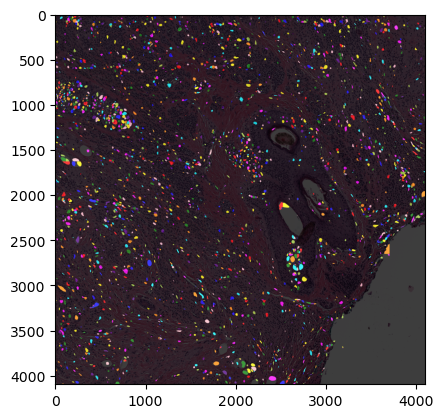

In [80]:
plt.imshow(z_grp["0/0"][0, :, 0, 4_000:4_000 + 4096, 5_000:5_000 + 4096].transpose(1, 2, 0))
plt.imshow(skimage.color.label2rgb(z_labels["0"][4_000:4_000 + 4096, 5_000:5_000 + 4096]), alpha=0.75)

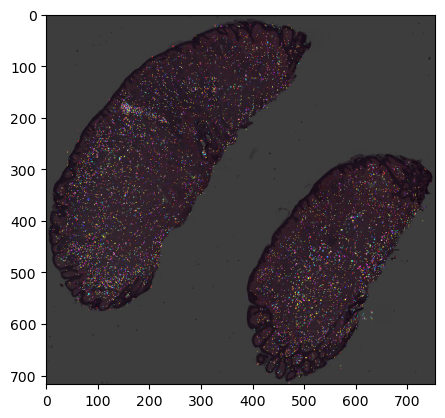

In [81]:
plt.imshow(z_grp["0/2"][0, :, 0].transpose(1, 2, 0))
plt.imshow(skimage.color.label2rgb(z_labels["5"][:]), alpha=0.75, extent=(0, z_grp["0/2"].shape[4], z_grp["0/2"].shape[3], 0))

In [82]:
client.shutdown()